# Transport Equation Solver ~~with Fourier Transform~~

In this notebook, we implement the numerical solver of the transport equation
$\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial (\rho v)}{\partial x} = 0 \end{equation} \tag*{}$
 on $(t,x)\in [0,1]\times [0,L]$ for a given $v:[0,1]\times [0,L]\to \mathbb{R}$ with a periodic boundary ~~using the discrete Fourier transform~~. In addition, we implement the calculation of the Wasserstein energy consistent with this method. This notebook is available at https://github.com/mao1756/pdot.

In [1]:
# Import relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

**For comparison, we first solve the problem without the Fourier transform.**

## The Staggered Grid
For the discretization of the time-space rectangle $[0,1]\times [0,L]$, we use the staggered grid, which is known to be more stable for fluid dynamical calculations. Let $N_0$ be the number of time steps and $N_1$ be the number of space steps. We introduce the **centered grid** 
$\begin{equation} \mathcal{G}_c = \left\{\left(\frac{i_0}{N_0}, L\frac{i_1+1/2}{N_1}\right)\middle| i_0= 0,\cdots ,N_0, i_1 = 0,\cdots N_1-1 \right\}.\end{equation} \tag*{}$
and the **space staggered grid**
$\begin{equation} \mathcal{G}_s^x = \left\{\left(\frac{i_0}{N_0}, L\frac{i_1}{N_1}\right)\middle| i_0= 0,\cdots ,N_0, i_1 = 0,\cdots N_1 \right\}\end{equation} \tag*{}$ 

We note that Papadakis et al. (2014) and Chizat et al. (2015) used the **time staggered grid** in addition, but we do not use that here because it does not translate well to our methodology. The main reason it does not work is that they use the momentum $\omega$ as their variable, but here we use the velocity vector field $v$ and find the momentum as $\omega = \rho v$.

# Functions
We define the following:
- $\rho^{c}_{i_0,i_1} = \rho(i_0/(N_0-1), L(i_1+1/2)/N_1)$ : The discretized mass on the centered grid
- $\rho^{sx}_{i_0,i_1} = \rho(i_0/(N_0-1),  Li_1/N_1)$: The discretized velocity mass on the space staggered grid
- $v^{sx}_{i_0,i_1} = v(i_0/(N_0-1),  Li_1/N_1)$: The discretized velocity field on the space staggered grid

The mass on the staggered grids and the one on the centered grids are related as follows:
$\begin{equation}\rho^{sx}_{i_0,i_1} = \frac{\rho^{c}_{i_0,i_1}+\rho^{c}_{i_0,i_1-1}}{2} \end{equation} \tag*{}$
For $i_1=0,N_1$, we use the periodicity to define the right hand side.

In short, we use $\rho^{c}$ and $v^{sx}$ as main variables, and find $\rho^{sx}$ by interpolation.

Finally, we define the staggered variable $U= (\rho^{sx})$ and the centered variable $V = (\rho^{c}, v^{c})$. 

In [2]:
class SVar(): 
    """ Staggered Variable.

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    psx: list of mass on the space staggered grids.
         psx[i] represents the mass on the staggered grid in the i+1 th space dimension.
    vsx: list of vector field on the space staggered grids
          vsx[i] represents the ith element of the velocity field on the staggered frid in the i+1 th space dimension.
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):
        self.cs = cs
        self.ll = ll
        size = [cs[0]+1, *cs[1:]]
        self.psx = [np.zeros(size) for _ in range(1, len(cs))]
        self.vsx = [np.zeros(size) for _ in range(1, len(cs))] 

class CVar():
    """Centered Variable.
    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    pc: mass on the centered grid.
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):         
        self.cs = cs
        self.ll = ll
        size = [cs[0]+1, *cs[1:]]
        self.pc = np.zeros(size)

class CSVar():
     """ The pair of the staggered variable and the centered variable.
     The implementation here is done in a D-dimensional space.
     Attributes:
     cs: the grid size (N_0, N_1, ..., N_D)
     ll: the size(s) of the space or L (list of L's if higher dimension)
     U: the staggered variable.
     V: the centered variable.
     """
     def __init__(self,
                 cs : List[int],
                 ll : List[float]):
        self.cs = cs
        self.ll = ll
        self.U = SVar(cs, ll)
        self.V = CVar(cs, ll)

     def interp(self):
        """ Using the centered mass, we find the staggered mass
        """
        for d in range(len(self.cs)-1):
          self.U.psx[d] = (self.V.pc + np.roll(self.V.pc, 1, d+1))/2

## The Discretization of The Transport Equation
We discretize the transport equation
$\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial (\rho v)}{\partial x} = 0 \end{equation}\tag*{}$
as follows:
$\begin{equation}\frac{\rho_{i_0+1,i_1}^c-\rho_{i_0,i_1}^c}{\Delta t} + \frac{(\rho v)_{i_0,i_{1}+1}^{sx}-(\rho v)_{i_0,i_1}^{sx}}{\Delta x} = 0\end{equation} \tag*{}$
which gives us the following update rule:
$\begin{equation}\rho_{i_0+1,i_1}^c = \rho_{i_0,i_1}^c - \Delta t \frac{(\rho v)_{i_0,i_{1}+1}^{sx}-(\rho v)_{i_0,i_1}^{sx}}{\Delta x} \tag*{}\end{equation}$

where $\Delta t  = 1/N_0$ and $\Delta x = L/N_1$.

In [3]:
class TransportEquation():
    """ The Transport Equation Solver

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the time/space or L (list of L's if higher dimension)
    L0 = total time, L1 = length of the first space dimension, ...
    var: the variables on the centered and the staggered grids
    """

    def __init__(self,
                 cs: List[int],
                 ll: List[int],
                 p0: np.ndarray,
                 vsx: np.ndarray):
        self.cs = cs
        self.ll = ll
        self.var = CSVar(cs, ll)
        self.var.V.pc[0] = p0
        self.var.interp()
        self.var.U.vsx = vsx
        self.dt = 1./self.cs[0]
        self.dx = np.array(self.ll[1:])/np.array(self.cs[1:])
    
    def solve(self):
        """ Solves the transport equation for the given conditions.
        """
        for i0 in range(self.cs[0]):
            div = sum((np.roll(self.var.U.psx[i][i0]*self.var.U.vsx[i][i0], -1, i) - \
                      self.var.U.psx[i][i0]*self.var.U.vsx[i][i0])/self.dx[i] for i in range(len(self.cs)-1))
            self.var.V.pc[i0+1] = self.var.V.pc[i0] -self.dt*div
            self.var.interp()

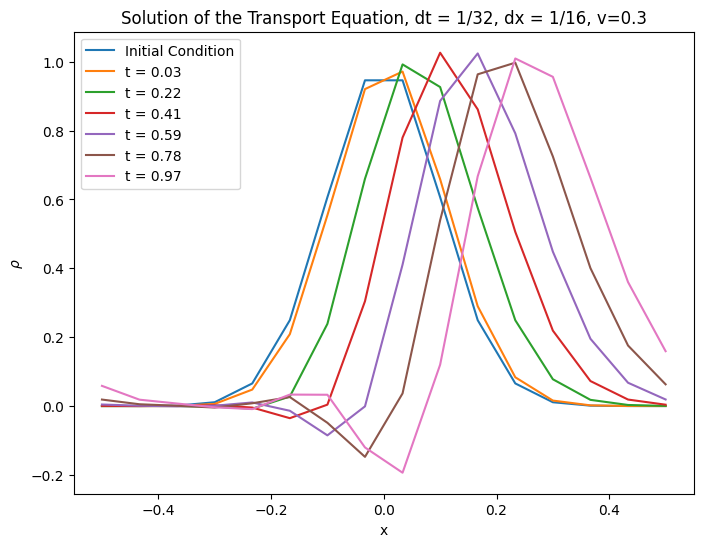

In [4]:
# Setting up the problem
cs = [32, 16]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = np.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = np.exp(-50*x**2)
v=0.3
vsx = [v*np.ones(size) for _ in range(1, len(cs))]


# Create a TransportEquation instance
transport_eq = TransportEquation(cs, ll, p0, vsx)
# Solve the transport equation
transport_eq.solve()

# Visualization
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, p0, label="Initial Condition")
for i in range(1, cs[0], cs[0]//5):
    ax.plot(x, transport_eq.var.V.pc[i], label=f"t = {ll[0]*i/cs[0]:.2f}")

ax.set_title(f"Solution of the Transport Equation, dt = 1/{cs[0]}, dx = 1/{cs[1]}, v={v}")
ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.legend()
plt.show()

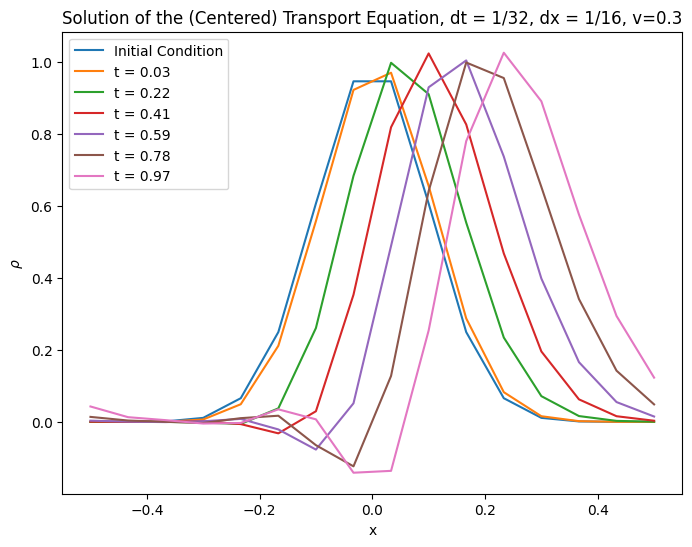

In [5]:
def transport_equation_1D_solver(rho_initial, v, dx, dt, t_max):
    """
    Solve the 1D transport equation using the FTCS scheme.
    
    Parameters:
    - rho_initial: Initial density distribution (1D array)
    - v: Velocity (constant for simplicity)
    - dx: Spatial step size
    - dt: Time step size
    - t_max: Maximum simulation time
    
    Returns:
    - rho_history: Density distribution at each time step (2D array)
    """
    
    # Determine the number of spatial points and time steps
    nx = len(rho_initial)
    nt = int(t_max / dt)
    
    # Initialize the density history with the initial distribution
    rho_history = np.zeros((nt, nx))
    rho_history[0] = rho_initial
    
    # Time loop
    for n in range(0, nt - 1):
        # Spatial loop (excluding boundaries for simplicity)
        for i in range(1, nx - 1):
            rho_history[n + 1, i] = rho_history[n, i] - v * dt / (2 * dx) * (rho_history[n, i + 1] - rho_history[n, i - 1])
        
        # Periodic boundary conditions
        rho_history[n + 1, 0] = rho_history[n, 0] - v * dt / (2 * dx) * (rho_history[n, 1] - rho_history[n, -1])
        rho_history[n + 1, -1] = rho_history[n, -1] - v * dt / (2 * dx) * (rho_history[n, 0] - rho_history[n, -2])
    
    return rho_history

# Parameters
nt = 32
nx = 16
x = np.linspace(-0.5, 0.5, nx)
rho_initial = np.exp(-50 * x**2)
dx = x[1] - x[0]
dt = 1./nt
t_max = 1
v = 0.3

# Solve the transport equation
rho_history = transport_equation_1D_solver(rho_initial, v, dx, dt, t_max)

# Visualization
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, rho_initial, label="Initial Condition")
nt = int(t_max / dt)
for i in range(1, nt, nt//5):
    ax.plot(x, rho_history[i], label=f"t = {t_max*i/nt:.2f}")
ax.set_title(f"Solution of the (Centered) Transport Equation, dt = 1/{nt}, dx = 1/{nx}, v={v:.1f}")
ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.legend()
plt.show()

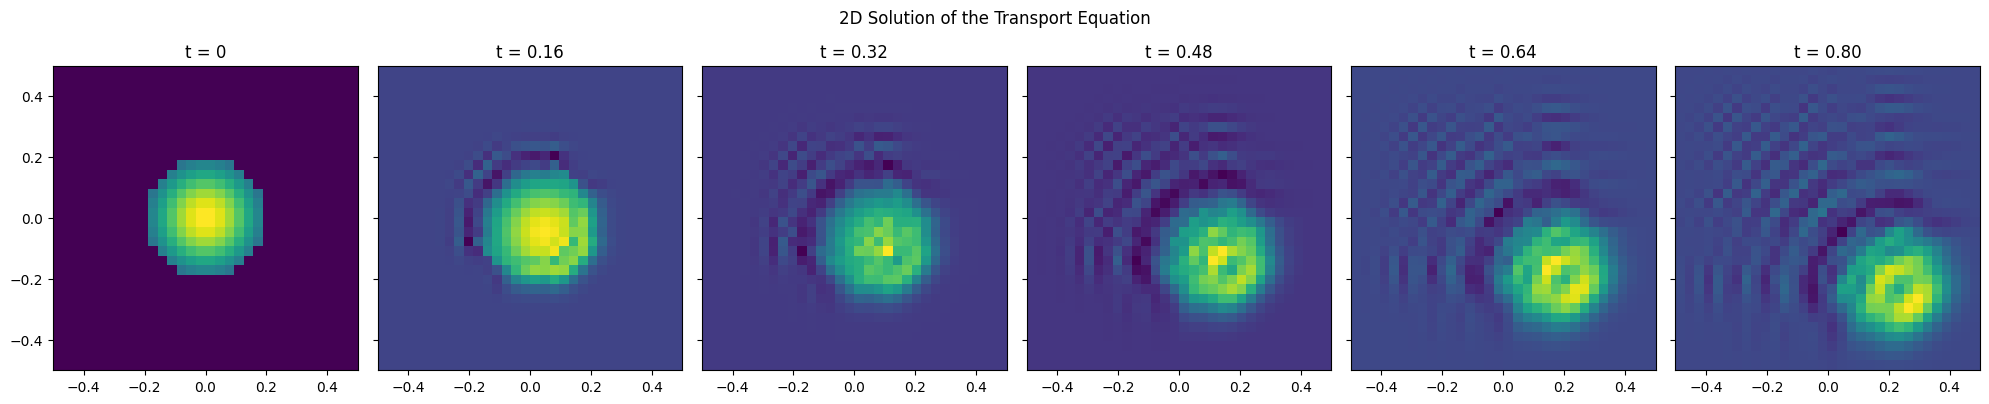

In [6]:
# 2D Circular Bump Example

# Setting up the problem
cs_2d = [100, 32, 32]  # [time steps, x spatial points, y spatial points]
ll_2d = [1.0, 1.0, 1.0]  # [total time, x spatial domain size, y spatial domain size]
x_2d = np.linspace(-ll_2d[1]/2, ll_2d[1]/2, cs_2d[1])
y_2d = np.linspace(-ll_2d[2]/2, ll_2d[2]/2, cs_2d[2])
X, Y = np.meshgrid(x_2d, y_2d)

# Circular bump initial condition
r = 0.2
p0_2d = np.exp(-(X**2 + Y**2)/r**2)
p0_2d[X**2 + Y**2 > r**2] = 0

# Rotating velocity field
#vx = -Y
#vy = X
#vsx_2d = [np.stack([vx, vy], axis=-1)]
# Constant vector field
size = [cs_2d[0]+1, *cs_2d[1:]]
vsx_2d = [0.3*np.ones(size) for _ in range(1, len(cs_2d))] 

# Create a TransportEquation instance
transport_eq_2d = TransportEquation(cs_2d, ll_2d, p0_2d, vsx_2d)

# Solve the transport equation
transport_eq_2d.solve()

# Visualization
fig_2d, axs_2d = plt.subplots(1, 6, figsize=(20,4), sharex=True, sharey=True)
axs_2d[0].imshow(p0_2d, extent=[-ll_2d[1]/2, ll_2d[1]/2, -ll_2d[2]/2, ll_2d[2]/2])
axs_2d[0].set_title("t = 0")

for i, ax in enumerate(axs_2d[1:], 1):
    idx = i * (cs_2d[0] // 6)
    ax.imshow(transport_eq_2d.var.V.pc[idx], extent=[-ll_2d[1]/2, ll_2d[1]/2, -ll_2d[2]/2, ll_2d[2]/2])
    ax.set_title(f"t = {ll_2d[0]*idx/cs_2d[0]:.2f}")

fig_2d.suptitle("2D Solution of the Transport Equation")
plt.tight_layout()
plt.show()

## Conclusion For the Non-Fourier Method

We have investigated the method of staggered grids and observed that it does not make much difference in this specific case.
We also observed the issue of negative densities.

For negative density, Boris (1976) mentions the following. Here, Eulerian methods mean the usual methods used above.
> In the case of Eulerian methods, the major outstanding weakness in a huge class of problems of real interest is the need for a large artificial damping (numerical diffusion) to fill in what would otherwise be pits of “negative density” in the calculated profiles.

That is, to ensure the positivity of the solution, we need to introduce an artificial diffusion term $\partial^2 \rho/\partial x^2$ to our numerical scheme to ensure the positivity. One way to do this is the upwind difference method, which uses the forward or the backward difference depending on the sign of the velocity field. This method however introduces non-smoothness to the problem, which would cause issues when we optimize the Wasserstein energy.

The paper by Boris is named Numerical Solutions of Continuity Equations, so maybe we can investigate the paper and use the methods mentioned there.

## Future Work
- Implement the method in the constrained dynamic OT paper
- Implement the proximal algorithm
- Implement the Fourier method
- Continue with the explicit finite difference method 